# Bienvenue à la OnSSET Notebook

Cette interface est construite sur le outil [OnSSET](http://www.onsset.org/) développé par la division KTH d'Energy Systems pour fournir un moyen simple et rapide de générer des scénarios d'investissement en électrification.

#### Commencez par importer le code

In [35]:
from onsset import *
import os
from IPython.display import display, Markdown, HTML
%matplotlib inline

2020-06-25 13:22:07,930		Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# 1. Sélection des données SIG

Tout d'abord, exécutez la cellule ci-dessous pour parcourir le répertoire dans lequel se trouve votre fichier CSV d'entrée et sélectionnez le fichier d'entrée. 

In [36]:
import tkinter as tk
from tkinter import filedialog, messagebox
from openpyxl import load_workbook
root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)
messagebox.showinfo('OnSSET', 'Ouvrez le fichier dentrée avec les données SIG extraites')
input_file = filedialog.askopenfilename()

onsseter = SettlementProcessor(input_file)
onsseter.df['IsUrban'] = 0
onsseter.df['Conflict'] = 0
onsseter.df['PerCapitaDemand'] = 0

# 2. Période de modélisation et taux d'électrification cible

Définissez ensuite la période de modélisation et le taux d'électrification à atteindre à la fin de l'analyse. Plus bas, vous définirez également une année et un objectif intermédiaires.

In [37]:
start_year = 2018
end_year = 2030

electrification_rate_target = 1 # Par exemple. 1 pour un taux d'électrification de 100% ou 0,80 pour un taux d'électrification de 80% 

#### Niveau cible de demande d'électricité
Ensuite, entrez le niveau cible (niveau d'accès à l'électricité) pour les ménages urbains et ruraux respectivement. Cela peut prendre une valeur comprise entre 1 (niveau d'accès à l'électricité le plus bas) et 5 (niveau d'accès à l'électricité le plus élevé) comme dans ESMAPs Multi-Tier Framework for Measuring Electricity Access (Trouvé <a href="https://www.esmap.org/node/55526" target="_blank">ici</a>). 

In [38]:
urban_target_tier = 4
rural_target_tier = 3

#### Objectif de taux d'électrification intermédiaire
Le modèle est configuré pour fonctionner en deux étapes. Saisissez l'année cible intermédiaire et le taux d'électrification cible pour cette année.

In [39]:
intermediate_year = 2025
intermediate_electrification_target = 0.75 # Par exemple. pour un taux d'électrification cible de 75%, entrez 0,75

#### Spécifications de la réseau
Cette partie peut être utilisée pour imposer des restrictions ou des extensions forcées du réseau. 

In [40]:
# Distance tampon (km) du réseau de grille actuel pour une connexion automatique au réseau.
auto_intensification = 2

# Il s'agit du nombre maximal de nouveaux ménages pouvant être connectés au réseau en un an (en milliers) par pas de temps
annual_new_grid_connections_limit = {intermediate_year: 146,
                                     end_year: 999999999}

# Il s'agit de la capacité de production maximale qui peut être ajoutée au réseau en un an (MW)
annual_grid_cap_gen_limit = {intermediate_year: 287,
                             end_year: 999999999}

# 3. Entrez les données spécifiques au pays

En plus des options ci-dessus, l'utilisateur peut personnaliser un grand nombre de variables décrivant l'environnement socio-économique-technologique du pays sélectionné.

**Remarque!** La plupart des valeurs d'entrée doivent représenter des estimations pour la variable valable tout au long de la période de modélisation, c'est-à-dire **NE PAS** valeurs actuelles.

### a. Composantes démographiques et sociales

In [41]:
pop_start_year = 44271000       ### Écrivez la population dans l'année de base (par exemple 2018)
end_year_pop = 63842360         ### Écrivez la population à la fin de l'année de l'analyse (par exemple 2030)

urban_ratio_start_year = 0.24   ### Écrire le ratio de population urbaine dans l'année de base (par exemple 2018)
urban_ratio_end_year = 0.31     ### Écrire le ratio de population urbaine à la fin de l'année (par exemple 2030)

num_people_per_hh_urban = 4.0     ### Écrivez le nombre de personnes par ménage urbain prévu pour la fin de l'année (par exemple 2030)
num_people_per_hh_rural = 3.4   ### Écrivez le nombre de personnes par ménage rural prévu pour la fin de l'année (par exemple 2030)

elec_ratio_start_year = 0.22   ### Écrivez le taux d'électrification dans l'année de base (par exemple 2018)
urban_elec_ratio = 0.577       ### Écrire le taux d'électrification urbaine dans l'année de base (par exemple 2018)
rural_elec_ratio = 0.11         ### Écrire le taux d'électrification rurale dans l'année de base (par exemple 2018)

### b. Spécifications et coûts technologiques

La cellule ci-dessous contient toutes les informations utilisées pour calculer les coûts nivelés pour toutes les technologies, y compris le réseau. Ces valeurs par défaut doivent être mises à jour pour refléter les valeurs les plus précises du pays. Il existe actuellement 7 technologies potentielles à inclure dans le modèle:
* Grille
* Mini-réseau PV
* Mini-réseau Eolienne
* Mini-réseau hydraulique
* Mini-réseau diesel
* Systèmes autonomes PV
* Systèmes autonomes diesel

Premièrement, décidez d'inclure ou non les technologies diesel:

In [42]:
diesel_techs = 0                      ### 0 = diesel NON inclus, 1 = diesel inclus

In [43]:
grid_generation_cost = 0.012           ### Il s'agit du coût de production d'électricité du réseau (USD / kWh) comme prévu à la fin de l'année de l'analyse
grid_power_plants_capital_cost = 2300 ### Le coût en USD / kW pour les améliorations de capacité des centrales électriques raccordées au réseau
grid_losses = 0.082                     ### La fraction d'électricité perdue lors du transport et de la distribution (pourcentage) 

In [44]:
diesel_price = 0.5                   ### Il s'agit du prix du diesel en USD / litre comme prévu à la fin de l'année de l'analyse.

In [45]:
sa_diesel_capital_cost = 938          ### Coût d'investissement en diesel autonome (USD / kW) comme prévu dans les années de l'analyse
mg_diesel_capital_cost = 721          ### Coût en capital du mini-réseau diesel (USD / kW) comme prévu dans les années de l'analyse
mg_pv_capital_cost = 2950             ### Coût en capital PV du mini-réseau (USD / kW) comme prévu dans les années de l'analyse
mg_wind_capital_cost = 3750           ### Coût en capital éolien du mini-réseau (USD / kW) comme prévu dans les années de l'analyse
mg_hydro_capital_cost = 3000          ### Coût en capital hydroélectrique du mini-réseau (USD / kW) comme prévu dans les années de l'analyse

In [46]:
sa_pv_capital_cost_1 = 9620          ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques de moins de 20 W
sa_pv_capital_cost_2 = 8780          ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques entre 21 et 50 W
sa_pv_capital_cost_3 = 6380           ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques de 51 à 100 W
sa_pv_capital_cost_4 = 4470           ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques de 101 à 1 000 W
sa_pv_capital_cost_5 = 6950           ### Coût en capital PV autonome (USD / kW) pour les systèmes domestiques de plus de 1 kW

Les cellules ci-dessous contiennent des spécifications technologiques supplémentaires

In [47]:
base_to_peak = 0.8                    ### Le rapport entre la demande moyenne du réseau et la demande de pointe (fraction) 
existing_grid_cost_ratio = 0.1        ### Le coût supplémentaire par cycle d'électrification (fraction)
discount_rate = 0.08 # Par exemple. 0,08 signifie un taux d'actualisation de 8%

# Coûts de transport et de distribution
hv_line_capacity=69 # kV
hv_line_cost=53000 # USD/km
mv_line_cost = 7000 # USD/kW
mv_line_capacity=50 # kV
mv_line_max_length=50 # km
mv_increase_rate=0.1
max_mv_line_dist = 50 # km
MV_line_amperage_limit = 8  # Ampere (A)
lv_line_capacity=0.24 #kV
lv_line_max_length=0.8 # km
lv_line_cost=4250 # USD/km
service_Transf_type=50  # kVa
service_Transf_cost=4250  # $/unit
max_nodes_per_serv_trans=300  # nombre maximal de nœuds desservis par chaque transformateur de service
hv_lv_transformer_cost=25000 # USD/unit
hv_mv_transformer_cost=25000 # USD/unit
mv_lv_transformer_cost=10000 # USD/unit
mv_mv_transformer_cost=10000 # USD/unit


# Centralized grid costs
grid_calc = Technology(om_of_td_lines=0.1,
                        distribution_losses=grid_losses,
                        connection_cost_per_hh=150,
                        base_to_peak_load_ratio=base_to_peak,
                        capacity_factor=1,
                        tech_life=30,
                        grid_capacity_investment=grid_power_plants_capital_cost,
                        grid_price=grid_generation_cost)

# Mini-grid hydro costs
mg_hydro_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.5,
                            tech_life=30,
                            capital_cost={float("inf"): mg_hydro_capital_cost},
                            om_costs=0.02,
                            )

# Mini-grid wind costs
mg_wind_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capital_cost={float("inf"): mg_wind_capital_cost},
                            om_costs=0.02,
                            tech_life=20,
                            )

# Mini-grid PV costs
mg_pv_calc = Technology(om_of_td_lines=0.03,
                        distribution_losses=0.05,
                        connection_cost_per_hh=100,
                        base_to_peak_load_ratio=0.85,
                        tech_life=20,
                        om_costs=0.02,
                        capital_cost={float("inf"): mg_pv_capital_cost}                        
                        )

# Stand-alone PV costs
sa_pv_calc = Technology(base_to_peak_load_ratio=0.9,
                        tech_life=15,
                        om_costs=0.02,
                        capital_cost={float("inf"): sa_pv_capital_cost_5,
                                      1: sa_pv_capital_cost_4,
                                      0.100: sa_pv_capital_cost_3,
                                      0.050: sa_pv_capital_cost_2,
                                      0.020: sa_pv_capital_cost_1},
                        standalone=True
                        )

# Mini-grid diesel costs
mg_diesel_calc = Technology(om_of_td_lines=0.02,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.7,
                            tech_life=15,
                            om_costs=0.1,
                            capital_cost={float("inf"): mg_diesel_capital_cost},
                            mini_grid=True)



# Stand-alone diesel costs
sa_diesel_calc = Technology(base_to_peak_load_ratio=0.9,
                            capacity_factor=0.5,
                            tech_life=10,
                            om_costs=0.1,
                            capital_cost={float("inf"): sa_diesel_capital_cost},
                            standalone=True)

Technology.set_default_values(base_year=start_year, start_year=start_year, end_year=end_year, discount_rate=discount_rate,
                             hv_line_type=hv_line_capacity, hv_line_cost=hv_line_cost, mv_line_type=mv_line_capacity,
                             mv_line_amperage_limit=MV_line_amperage_limit, mv_line_cost=mv_line_cost, lv_line_type=lv_line_capacity,
                             lv_line_cost=lv_line_cost, lv_line_max_length=lv_line_max_length, 
                             service_transf_type=service_Transf_type, service_transf_cost = service_Transf_cost,
                             max_nodes_per_serv_trans=max_nodes_per_serv_trans, mv_lv_sub_station_cost=mv_lv_transformer_cost,
                             mv_mv_sub_station_cost=mv_mv_transformer_cost, hv_lv_sub_station_cost=hv_lv_transformer_cost,
                             hv_mv_sub_station_cost=hv_mv_transformer_cost)

# 4. Importation et traitement de données SIG

OnSSET est un outil basé sur le SIG et son bon fonctionnement dépend fortement de la préparation et de l'étalonnage diligents des données géospatiales nécessaires. La cellule suivante lit le fichier CSV contenant les données SIG extraites pour le pays choisi dans la section précédente et affiche un instantané de certaines des données.

In [49]:
yearsofanalysis = [intermediate_year, end_year]

onsseter.condition_df()
onsseter.df[SET_GRID_PENALTY] = onsseter.grid_penalties(onsseter.df)
onsseter.df[SET_WINDCF] = onsseter.calc_wind_cfs()
pop_modelled, urban_modelled = onsseter.calibrate_current_pop_and_urban(pop_start_year, urban_ratio_start_year)
onsseter.project_pop_and_urban(pop_start_year, end_year_pop, end_year_pop, urban_ratio_start_year, 
                                 urban_ratio_end_year, start_year, end_year, intermediate_year)

eleclimits = {intermediate_year: intermediate_electrification_target, end_year: electrification_rate_target}
time_steps = {intermediate_year: intermediate_year-start_year, end_year: end_year-intermediate_year}

display(Markdown('#### Le fichier csv a été importé correctement. Voici un aperçu:'))
display(onsseter.df[['Country','Pop','NightLights','TravelHours','GHI','WindVel','Hydropower','HydropowerDist']].sample(7))

for year in yearsofanalysis:
    mg_diesel_cost = {'diesel_price': diesel_price,
                      'efficiency': 0.33,
                      'diesel_truck_consumption': 33.7,
                      'diesel_truck_volume': 15000}

    sa_diesel_cost = {'diesel_price': diesel_price,
                      'efficiency': 0.28,
                      'diesel_truck_consumption': 14,
                      'diesel_truck_volume': 300}

    onsseter.diesel_cost_columns(sa_diesel_cost, mg_diesel_cost, year)


2020-06-25 13:26:51,900		Ensure that columns that are supposed to be numeric are numeric
2020-06-25 13:26:51,918		Replace null values with zero
2020-06-25 13:26:51,942		Sort by country, Y and X
2020-06-25 13:26:52,005		Classify road dist
2020-06-25 13:26:52,011		Classify substation dist
2020-06-25 13:26:52,016		Classify elevation
2020-06-25 13:26:52,024		Classify slope
2020-06-25 13:26:52,031		Classify land cover
2020-06-25 13:26:52,075		Combined classification
2020-06-25 13:26:52,081		Grid penalty
2020-06-25 13:26:52,086		Calculate Wind CF
2020-06-25 13:26:54,262		Population calibration process
2020-06-25 13:26:55,519		Urban/rural calibration process


The calibrated population differs by 0.00. In case this is not acceptable please revise this part of the code


2020-06-25 13:26:55,986		Population projection process


#### Le fichier csv a été importé correctement. Voici un aperçu:

,Country,Pop,NightLights,TravelHours,GHI,WindVel,Hydropower,HydropowerDist
22501,Benin,25.49086,0.0,1.20000,1810.0,3.98268,137.561,35.85067
40382,Benin,12.50476,0.0,2.16667,1971.0,3.95990,9758.860,53.95767
33938,Benin,6.25454,0.0,1.70000,1967.0,3.15151,287.406,18.15291
3002,Benin,33.97820,0.0,0.68421,1721.0,3.64298,290.099,18.61276
16145,Benin,14.58634,0.0,0.45000,1745.0,3.61270,375.877,8.12787
57442,Benin,45.08756,0.0,0.28333,2000.0,4.08204,113.160,55.52561
83515,Benin,61.71259,0.0,0.55000,2080.0,4.06226,224.466,25.12268


#### Étalonnage des colonies actuellement électrifiées

Le modèle calibre les établissements susceptibles d'être électrifiés au cours de l'année de démarrage, pour correspondre aux valeurs statistiques nationales définies ci-dessus. Un règlement est considéré comme électrifié s'il remplit toutes les conditions suivantes:
- A plus de lumières nocturnes que le seuil défini (ce paramètre est défini sur 0 par défaut)
- Est plus proche du réseau de distribution existant que la limite de distance
- A plus de population que le seuil

Définissez d'abord les seuils. Exécutez ensuite l'étalonnage et vérifiez si les résultats semblent corrects. Sinon, redéfinissez ces seuils et exécutez à nouveau.

In [50]:
min_night_lights = 0    ### 0 Indique l'absence de veilleuse, tandis que n'importe quel nombre ci-dessus fait référence à l'intensité des veilleuses
min_pop = 100      ### Population de peuplement au-dessus de laquelle on peut supposer qu'elle pourrait être électrifiée
   
max_mv_line_distance = 3 ### Distance en km du réseau de distribution existant en dessous de laquelle nous pouvons supposer qu'un règlement pourrait être électrifié
max_hv_line_distance = 25

elec_modelled, urban_internal_elec_ratio, rural_internal_elec_ratio = onsseter.elec_current_and_future(elec_ratio_start_year, 
                                                                                                       urban_elec_ratio, 
                                                                                                       rural_elec_ratio, 
                                                                                                       start_year,
                                                                                                       min_night_lights=min_night_lights, 
                                                                                                       min_pop=min_pop, 
                                                                                                       max_transformer_dist=2, 
                                                                                                       max_mv_dist=max_mv_line_distance, 
                                                                                                       max_hv_dist=max_hv_line_distance) 

2020-06-25 13:28:10,105		Calibrate current electrification


We have identified the existence of transformers or MV lines as input data; therefore we proceed using those for the calibration
The modelled electrification rate differ by 0.00. Urban elec. rate differ by -0.00 and Rural elec. rate differ by -0.00. 
If this is not acceptable please revise this part of the algorithm


La figure ci-dessous montre les résultats de l'étalonnage. Les colonies en **bleu** sont considérées comme (au moins en partie) électrifiées dès le début de l'analyse, tandis que les colonies en **jaune** ne sont pas encore électrifiées. Réexécuter l'étape d'étalonnage avec différentes valeurs initiales peut modifier la carte ci-dessous.

<Figure size 2160x2160 with 0 Axes>

2020-06-25 13:28:46,517		update_title_pos
2020-06-25 13:28:46,578		update_title_pos
2020-06-25 13:28:46,640		update_title_pos
2020-06-25 13:28:46,672		update_title_pos
2020-06-25 13:28:46,695		update_title_pos


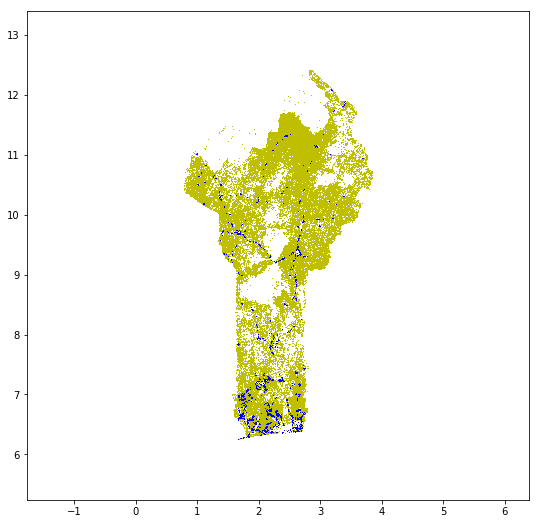

<Figure size 2160x2160 with 0 Axes>

In [51]:
from matplotlib import pyplot as plt
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
plt.figure(figsize=(9,9))
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_Y_DEG], 'y,')
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_Y_DEG], 'b,')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))

# 5. Définir la demande

Ce morceau de code définit la demande d'électricité cible dans la région/le pays. La demande d'électricité résidentielle est définie comme kWh / ménage / an, tandis que toutes les autres demandes sont définies comme kWh/habitant/an. Notez qu'à l'heure actuelle, toutes les demandes d'utilisation productive sont définies sur 0 par défaut.

In [52]:
# Définir les objectifs annuels d'électricité domestique à choisir
tier_1 = 38.7  # 38.7 fait référence à kWh/ménage/an. 
tier_2 = 219
tier_3 = 803
tier_4 = 2117
tier_5 = 2993

onsseter.prepare_wtf_tier_columns(num_people_per_hh_rural, num_people_per_hh_urban, tier_1, tier_2, tier_3, tier_4, tier_5)

2020-06-25 13:29:06,182		Populate ResidentialDemandTier columns


In [53]:
onsseter.df[SET_EDU_DEMAND] = 0           # Demande d'établissements d'enseignement (kWh / habitant / an)
onsseter.df[SET_HEALTH_DEMAND] = 0        # Demande d'établissements de santé (kWh / habitant / an)
onsseter.df[SET_COMMERCIAL_DEMAND] = 0    # Demande d'activités commerciales (kWh / habitant / an)
onsseter.df[SET_AGRI_DEMAND] = 0          # Demande d'activités agricoles (kWh / habitant / an)
productive_demand = 0 # 1 si la demande productive est définie et doit être incluse, sinon 0

# 6. Lancer une exécution de scénario, qui calcule et compare les coûts technologiques pour chaque règlement dans le pays

Sur la base du calcul précédent, ce morceau de code identifie le LCoE que chaque technologie hors réseau peut fournir, pour chaque règlement peuplé unique du pays sélectionné. La cellule prend ensuite tous les points actuellement connectés au réseau dans le pays et examine les points à une certaine distance d'eux, pour voir s'il est plus économique de les connecter au réseau, ou d'utiliser l'un des hors-réseau technologies calculées ci-dessus. Une fois que d'autres points sont connectés au réseau, le processus est répété, de sorte que de nouveaux points proches de ces points peuvent également être connectés. Cette opération est répétée jusqu'à ce qu'il n'y ait plus de nouveaux points à connecter au réseau.

In [54]:
onsseter.current_mv_line_dist()

for year in yearsofanalysis:
    end_year_pop = 1
    prioritization = 2
        
    eleclimit = eleclimits[year]
    time_step = time_steps[year]
    grid_cap_gen_limit = time_step * annual_grid_cap_gen_limit[year] * 1000
    grid_connect_limit = time_step * annual_new_grid_connections_limit[year] * 1000
    
    onsseter.set_scenario_variables(year, num_people_per_hh_rural, num_people_per_hh_urban, time_step,
                                            start_year, urban_target_tier, 
                                            rural_target_tier, end_year_pop, productive_demand)

    sa_diesel_investment, sa_pv_investment, mg_diesel_investment, mg_pv_investment, mg_wind_investment, \
                                        mg_hydro_investment = onsseter.calculate_off_grid_lcoes(mg_hydro_calc, mg_wind_calc, mg_pv_calc,
                                                                                                sa_pv_calc, mg_diesel_calc,
                                                                                                sa_diesel_calc, year, end_year, time_step)
    grid_investment, grid_cap_gen_limit, grid_connect_limit = \
                                        onsseter.pre_electrification(grid_generation_cost, year, time_step, end_year, grid_calc, grid_cap_gen_limit,
                                                                     grid_connect_limit)

    onsseter.df[SET_LCOE_GRID + "{}".format(year)], onsseter.df[SET_MIN_GRID_DIST + "{}".format(year)], \
                                    onsseter.df[SET_ELEC_ORDER + "{}".format(year)], onsseter.df[SET_MV_CONNECT_DIST], grid_investment = \
                                        onsseter.elec_extension(grid_calc,
                                                                mv_line_max_length,
                                                                year,
                                                                start_year,
                                                                end_year,
                                                                time_step,
                                                                grid_cap_gen_limit,
                                                                grid_connect_limit,
                                                                auto_intensification=auto_intensification,
                                                                prioritization=prioritization,
                                                                new_investment=grid_investment)

    onsseter.results_columns(year, time_step, prioritization, auto_intensification)

    onsseter.calculate_investments(sa_diesel_investment, sa_pv_investment, mg_diesel_investment,
                                   mg_pv_investment, mg_wind_investment,
                                   mg_hydro_investment, grid_investment, year)

    onsseter.apply_limitations(eleclimit, year, time_step, prioritization, auto_intensification)

    onsseter.calculate_new_capacity(mg_hydro_calc, mg_wind_calc, mg_pv_calc, sa_pv_calc, mg_diesel_calc,
                                                                    sa_diesel_calc, grid_calc, year)    

2020-06-25 13:37:48,079		Determine current MV line length
2020-06-25 13:37:48,188		Calculate new connections
2020-06-25 13:37:48,297		Setting electrification demand as per target per year
2020-06-25 13:37:48,665		Calculate minigrid hydro LCOE
2020-06-25 13:37:49,021		Calculate minigrid PV LCOE
2020-06-25 13:37:49,351		Calculate minigrid wind LCOE
2020-06-25 13:37:49,717		Calculate standalone PV LCOE
2020-06-25 13:37:50,041		Determine minimum technology (off-grid)
2020-06-25 13:37:50,500		Determine minimum tech LCOE
2020-06-25 13:37:50,726		Define the initial electrification status
2020-06-25 13:37:51,817		Initially 1869 electrified
2020-06-25 13:37:52,463		Electrification loop 1 with 1869 electrified
2020-06-25 13:37:53,617		Calculate investment cost
2020-06-25 13:37:53,639		Determine electrification limits
2020-06-25 13:37:53,998		Determine final electrification decision
2020-06-25 13:37:54,064		Calculate new capacity
2020-06-25 13:37:54,182		Calculate new connections


The electrification rate achieved in 2025 is 75.0 %


2020-06-25 13:37:54,330		Setting electrification demand as per target per year
2020-06-25 13:37:54,434		Calculate minigrid hydro LCOE
2020-06-25 13:37:54,735		Calculate minigrid PV LCOE
2020-06-25 13:37:55,100		Calculate minigrid wind LCOE
2020-06-25 13:37:55,449		Calculate standalone PV LCOE
2020-06-25 13:37:55,787		Determine minimum technology (off-grid)
2020-06-25 13:37:56,277		Determine minimum tech LCOE
2020-06-25 13:37:56,527		Define the initial electrification status
2020-06-25 13:37:57,739		Initially 21514 electrified
2020-06-25 13:37:58,402		Electrification loop 1 with 33271 electrified
2020-06-25 13:37:59,624		Electrification loop 2 with 12512 electrified
2020-06-25 13:38:00,362		Electrification loop 3 with 2910 electrified
2020-06-25 13:38:01,023		Electrification loop 4 with 634 electrified
2020-06-25 13:38:01,622		Electrification loop 5 with 143 electrified
2020-06-25 13:38:02,275		Electrification loop 6 with 46 electrified
2020-06-25 13:38:02,937		Electrification loop 7 wi

The electrification rate achieved in 2030 is 100.0 %


# 7. Résultats, résumés et visualisation
Une fois tous les calculs et extensions de réseau terminés, ce bloc obtient les résultats finaux sur la technologie choisie pour chaque point, la quantité de capacité à installer et son coût. Ensuite, les résumés, les graphiques et les cartes sont générés.

In [55]:
elements = []
for year in yearsofanalysis:
    elements.append("Population{}".format(year))
    elements.append("NewConnections{}".format(year))
    elements.append("Capacity{}".format(year))
    elements.append("Investment{}".format(year))

techs = ["Grid", "SA_Diesel", "SA_PV", "MG_Diesel", "MG_PV", "MG_Wind", "MG_Hydro"]

sumtechs = []
for year in yearsofanalysis:
    sumtechs.extend(["Population{}".format(year) + t for t in techs])
    sumtechs.extend(["NewConnections{}".format(year) + t for t in techs])
    sumtechs.extend(["Capacity{}".format(year) + t for t in techs])
    sumtechs.extend(["Investment{}".format(year) + t for t in techs])

summary = pd.Series(index=sumtechs, name='country')

for year in yearsofanalysis:
    for t in techs:
        summary.loc["Population{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)), SET_POP + '{}'.format(year)].sum()
        summary.loc["NewConnections{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CONNECTIONS + '{}'.format(year)].sum()
        summary.loc["Capacity{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CAPACITY + '{}'.format(year)].sum()/1000
        summary.loc["Investment{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_INVESTMENT_COST + '{}'.format(year)].sum()
        
index = techs + ['Total']
columns = []
for year in yearsofanalysis:
    columns.append("Population{}".format(year))
    columns.append("NewConnections{}".format(year))
    columns.append("Capacity{} (MW)".format(year))
    columns.append("Investment{} (million USD)".format(year))
                                                                                                                                           
summary_table = pd.DataFrame(index=index, columns=columns)

summary_table[columns[0]] = summary.iloc[0:7].astype(int).tolist() + [int(summary.iloc[0:7].sum())]
summary_table[columns[1]] = summary.iloc[7:14].astype(int).tolist() + [int(summary.iloc[7:14].sum())]
summary_table[columns[2]] = summary.iloc[14:21].astype(int).tolist() + [int(summary.iloc[14:21].sum())]
summary_table[columns[3]] = [round(x/1e4)/1e2 for x in summary.iloc[21:28].astype(float).tolist()] + [round(summary.iloc[21:28].sum()/1e4)/1e2]
summary_table[columns[4]] = summary.iloc[28:35].astype(int).tolist() + [int(summary.iloc[28:35].sum())]
summary_table[columns[5]] = summary.iloc[35:42].astype(int).tolist() + [int(summary.iloc[35:42].sum())]
summary_table[columns[6]] = summary.iloc[42:49].astype(int).tolist() + [int(summary.iloc[42:49].sum())]
summary_table[columns[7]] = [round(x/1e4)/1e2 for x in summary.iloc[49:56].astype(float).tolist()] + [round(summary.iloc[49:56].sum()/1e4)/1e2]

In [56]:
display(Markdown('### Summary \n Ce sont les résultats résumés pour lélectrification complète du pays sélectionné dici la dernière année'))
summary_table

### Summary 
 Ce sont les résultats résumés pour lélectrification complète du pays sélectionné dici la dernière année

,Population2025,NewConnections2025,Capacity2025 (MW),Investment2025 (million USD),Population2030,NewConnections2030,Capacity2030 (MW),Investment2030 (million USD)
Grid,32175427,22435807,1254,4662.76,61659418,21459811,969,2743.93
SA_Diesel,0,0,0,0.00,0,0,0,0.00
SA_PV,3578223,742504,86,386.75,2035745,1293241,158,440.47
MG_Diesel,0,0,0,0.00,0,0,0,0.00
MG_PV,18627316,7889608,1111,3818.72,38234,38234,5,12.70
MG_Wind,0,0,0,0.00,0,0,0,0.00
MG_Hydro,220615,143614,8,35.04,18020,8977,0,2.39
Total,54601583,31211535,2460,8903.26,63751420,22800264,1134,3199.48


2020-06-25 13:38:05,818		update_title_pos
2020-06-25 13:38:05,890		update_title_pos
2020-06-25 13:38:05,929		update_title_pos
2020-06-25 13:38:05,976		update_title_pos
2020-06-25 13:38:06,025		update_title_pos
2020-06-25 13:38:06,054		update_title_pos
2020-06-25 13:38:06,096		update_title_pos
2020-06-25 13:38:06,135		update_title_pos
2020-06-25 13:38:06,261		update_title_pos
2020-06-25 13:38:06,284		update_title_pos
2020-06-25 13:38:06,310		update_title_pos
2020-06-25 13:38:06,334		update_title_pos
2020-06-25 13:38:06,400		update_title_pos
2020-06-25 13:38:06,420		update_title_pos
2020-06-25 13:38:06,445		update_title_pos
2020-06-25 13:38:06,469		update_title_pos
2020-06-25 13:38:06,511		update_title_pos
2020-06-25 13:38:06,551		update_title_pos
2020-06-25 13:38:06,581		update_title_pos
2020-06-25 13:38:06,611		update_title_pos


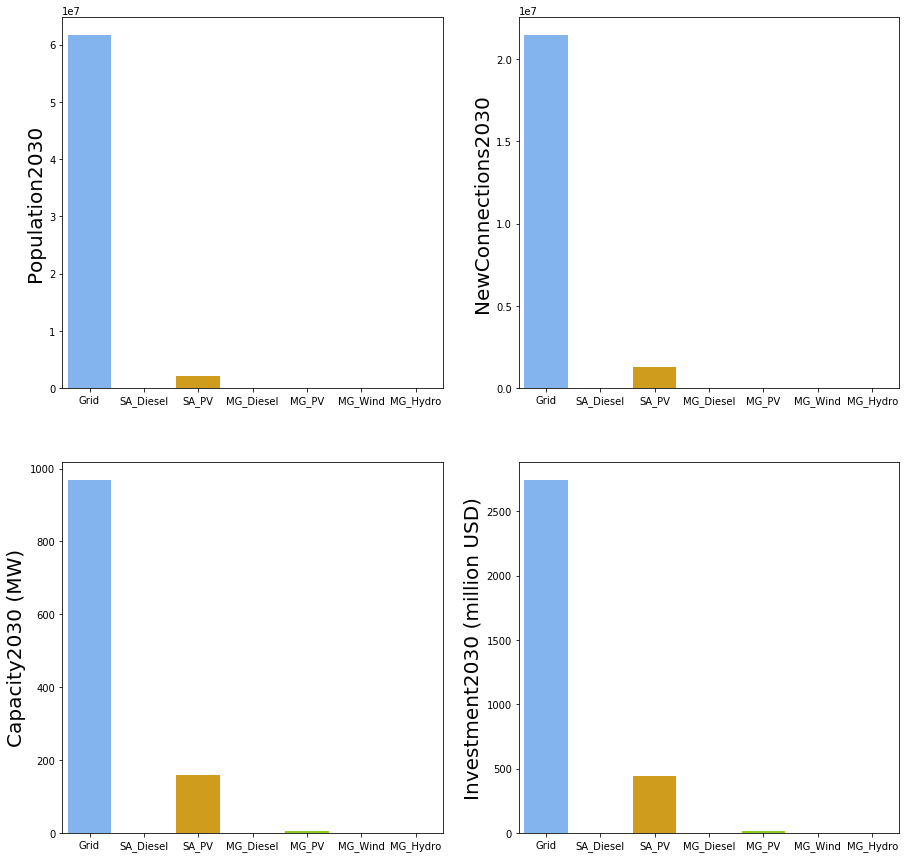

In [57]:
import matplotlib.pylab as plt
import seaborn as sns

colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
techs_colors = dict(zip(techs, colors))

summary_plot=summary_table.drop(labels='Total',axis=0)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size
f, axarr = plt.subplots(2, 2)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size

sns.barplot(x=summary_plot.index.tolist(), y=columns[4], data=summary_plot, ax=axarr[0, 0], palette=colors)
axarr[0, 0].set_ylabel(columns[4], fontsize=2*font_size)
axarr[0, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[5], data=summary_plot, ax=axarr[0, 1], palette=colors)
axarr[0, 1].set_ylabel(columns[5], fontsize=2*font_size)
axarr[0, 1].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[6], data=summary_plot, ax=axarr[1, 0], palette=colors)
axarr[1, 0].set_ylabel(columns[6], fontsize=2*font_size)
axarr[1, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[7], data=summary_plot, ax=axarr[1, 1], palette=colors)
axarr[1, 1].set_ylabel(columns[7], fontsize=2*font_size)
axarr[1, 1].tick_params(labelsize=font_size)

<Figure size 2160x2160 with 0 Axes>

2020-06-25 13:38:06,800		update_title_pos
2020-06-25 13:38:06,884		update_title_pos
2020-06-25 13:38:06,969		update_title_pos
2020-06-25 13:38:07,018		update_title_pos
2020-06-25 13:38:07,050		update_title_pos


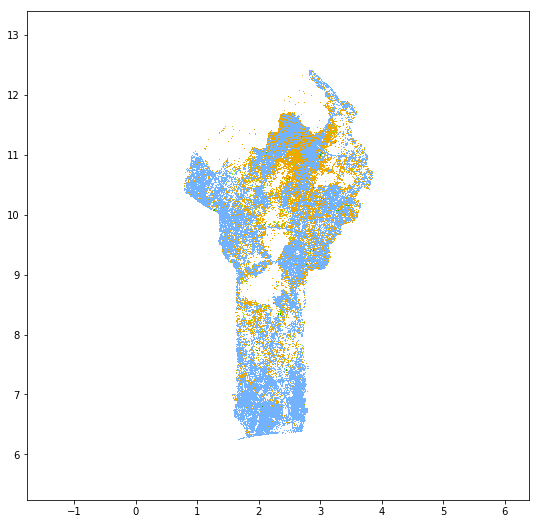

<Figure size 2160x2160 with 0 Axes>

In [58]:
from matplotlib import pyplot as plt
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
plt.figure(figsize=(9,9))
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_Y_DEG], color='#EDA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_Y_DEG], color='#EDD100', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_Y_DEG], color='#1F6600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_Y_DEG], color='#98E600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_Y_DEG], color='#70A800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_Y_DEG], color='#1FA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_Y_DEG], color='#73B2FF', marker=',', linestyle='none')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))

## 9. Exportation des résultats

Ce code génère trois fichiers csv:
 - un contenant tous les résultats du scénario créé
 - un contenant le résumé du scénario créé
 - un contenant certains si les variables d'entrée clés du scénario

Avant de continuer, veuillez écrire le nom du scénario dans la première cellule ci-dessous. passez ensuite à la cellule suivante et exécutez-la pour parcourir le répertoire dans lequel vous souhaitez enregistrer vos résultats. 

**Notez que si vous ne modifiez pas le nom du scénario, les fichiers de sortie précédents seront remplacés**

In [ ]:
scenario_name = "scenario_name"

In [ ]:
list1 = [('Start_year',start_year,'','',''), 
         ('End_year',end_year,'','',''),
         ('End year electrification rate target',electrification_rate_target,'','',''),
         ('Intermediate target year', intermediate_year,'','',''),
         ('Intermediate electrification rate target', intermediate_electrification_target,'','',''),
         ('Urban target tier', urban_target_tier, '', '', ''),
         ('Rural target tier', rural_target_tier, '', '', ''),
         ('Prioritization', prioritization,'','','1 = baseline, 2 = intensification'),
         ('Auto intensification distance', auto_intensification, '', '', 'Buffer distance (km) for automatic intensification if choosing prioritization 1'),
         ('discount_rate',discount_rate,'','',''),
         ('pop_start_year',pop_start_year,'','','the population in the base year (e.g. 2016)'),
         ('pop_end_year',end_year_pop,'','','the projected population in the end year (e.g. 2030)'),
         ('urban_ratio_start_year',urban_ratio_start_year,'','','the urban population population ratio in the base year (e.g. 2016)'),
         ('urban_ratio_end_year',urban_ratio_end_year,'','','the urban population population ratio in the end year (e.g. 2030)'),
         ('num_people_per_hh_urban',num_people_per_hh_urban,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('num_people_per_hh_rural',num_people_per_hh_rural,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('elec_ratio_start_year',elec_ratio_start_year,'','','the electrification rate in the base year (e.g. 2016)'),
         ('urban_elec_ratio',urban_elec_ratio,'','','urban electrification rate in the base year (e.g. 2016)'),
         ('rural_elec_ratio',rural_elec_ratio,'','','rural electrification rate in the base year (e.g. 2016)'),
         ('grid_generation_cost',grid_generation_cost,'','','This is the grid cost electricity USD/kWh as expected in the end year of the analysis'),
         ('grid_power_plants_capital_cost',grid_power_plants_capital_cost,'','','The cost in USD/kW to for capacity upgrades of the grid-connected power plants'),
         ('grid_losses',grid_losses,'','','The fraction of electricity lost in transmission and distribution (percentage)'),
         ('base_to_peak',base_to_peak,'','','The ratio of base grid demand to peak demand (percentage)'),
         ('existing_grid_cost_ratio',existing_grid_cost_ratio,'','','The additional cost per round of electrification (percentage)'),
         ('diesel_price',diesel_price,'','','This is the diesel price in USD/liter as expected in the end year of the analysis'),
         ('sa_diesel_capital_cost',sa_diesel_capital_cost,'','','Stand-alone Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_diesel_capital_cost',mg_diesel_capital_cost,'','','Mini-grid Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_pv_capital_cost',mg_pv_capital_cost,'','','Mini-grid PV capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_wind_capital_cost',mg_wind_capital_cost,'','','Mini-grid Wind capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_hydro_capital_cost',mg_hydro_capital_cost,'','','Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis'),
         ('sa_pv_capital_cost_1',sa_pv_capital_cost_1,'','','Stand-alone PV capital cost (USD/kW) for household systems under 20 W'),
         ('sa_pv_capital_cost_2',sa_pv_capital_cost_2,'','','Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W'),
         ('sa_pv_capital_cost_3',sa_pv_capital_cost_3,'','','Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W'),
         ('sa_pv_capital_cost_4',sa_pv_capital_cost_4,'','','Stand-alone PV capital cost (USD/kW) for household systems between 101-200 W'),
         ('sa_pv_capital_cost_5',sa_pv_capital_cost_5,'','','Stand-alone PV capital cost (USD/kW) for household systems over 200 W'),
         ('mv_line_cost',mv_line_cost,'','','Cost of MV lines in USD/km'),
         ('lv_line_cost',lv_line_cost,'','','Cost of LV lines in USD/km'),
         ('mv_line_capacity',mv_line_capacity,'','','Capacity of MV lines in kW/line'),
         ('lv_line_capacity',lv_line_capacity,'','','Capacity of LV lines in kW/line'),
         ('lv_line_max_length',lv_line_max_length,'','','Maximum length of LV lines (km)'),
         ('hv_line_cost',hv_line_cost,'','','Cost of HV lines in USD/km'),
         ('mv_line_max_length',mv_line_max_length,'','','Maximum length of MV lines (km)'),
         ('hv_lv_transformer_cost',hv_lv_transformer_cost,'','','Cost of HV/MV transformer (USD/unit)'),
         ('mv_increase_rate',mv_increase_rate,'','','percentage'),
         ('max_grid_extension_dist',max_mv_line_dist,'','','Maximum distance that the grid may be extended by means of MV lines'),
         ('annual_new_grid_connections_limit', annual_new_grid_connections_limit,'','','This is the maximum amount of new households that can be connected to the grid in one year (thousands)'),
         ('grid_capacity_limit',annual_grid_cap_gen_limit,'','','This is the maximum generation capacity that can be added to the grid in one year (MW)'),
        ]
labels = ['Variable','Value', 'Source', 'Comments', 'Description']
df_variables = pd.DataFrame.from_records(list1, columns=labels)

In [ ]:
messagebox.showinfo('OnSSET', 'Accédez au dossier dans lequel vous souhaitez enregistrer les sorties')

output_dir = filedialog.askdirectory()
output_dir_variables = os.path.join(output_dir, '{}_Variables.csv'.format(scenario_name))
output_dir_results = os.path.join(output_dir, '{}_Results.csv'.format(scenario_name))
output_dir_summaries = os.path.join(output_dir, '{}_Summaries.csv'.format(scenario_name))

In [ ]:
# Returning the result as a csv file
onsseter.df.to_csv(output_dir_results, index=False)

# Returning the summary as a csv file
summary_table.to_csv(output_dir_summaries, index=True)

# Returning the input variables as a csv file
df_variables.to_csv(output_dir_variables, index=False)